In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Baseline_Merchant_Revenue.xlsx to Baseline_Merchant_Revenue (1).xlsx
Saving Hourly_Forward_Prices_All_Markets.xlsx to Hourly_Forward_Prices_All_Markets (2).xlsx
Saving Forward_Curve_From_History.xlsx to Forward_Curve_From_History (3).xlsx
Saving HackathonDataset (3).xlsx to HackathonDataset (3) (3).xlsx


Columns: ['Year', 'Hourly_Revenue', 'Projected_Gen_MWh', 'Effective_Price', 'Market']


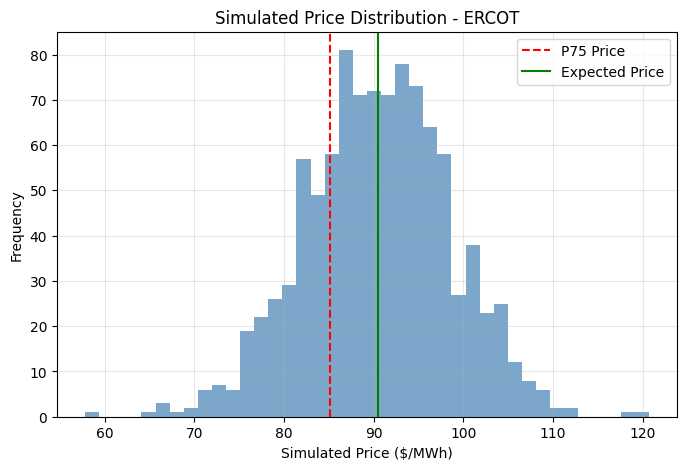

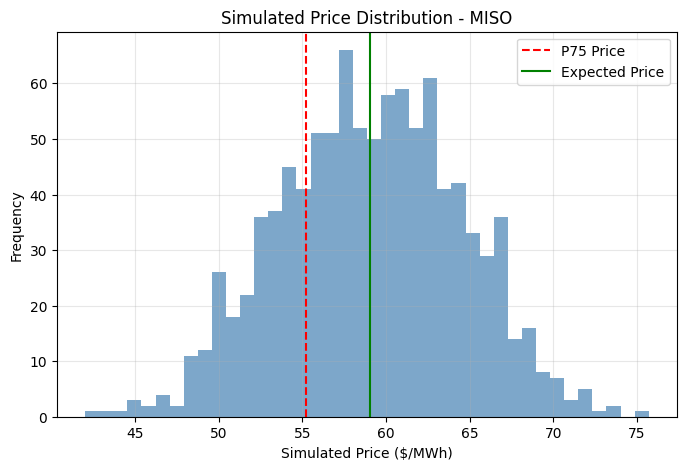

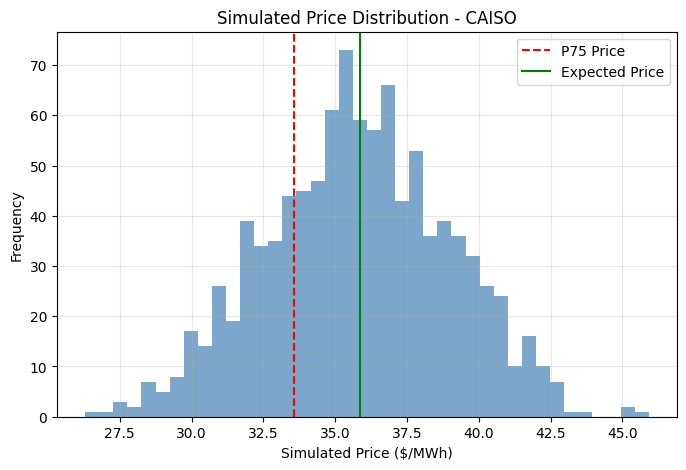

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Monte Carlo completed.
  Market  Expected_Price  P75_Hedge_Price
0  ERCOT       90.504239        85.128396
1   MISO       59.034836        55.226420
2  CAISO       35.858039        33.580501


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('Baseline_Merchant_Revenue.xlsx')

df.columns = df.columns.str.strip().str.replace(' ', '_')


print("Columns:", df.columns.tolist())


price_vol = 0.20    # 20% price volatility — adjust per market
gen_vol = 0.05      # 5% generation volatility
n_sim = 1000        # number of simulation runs
np.random.seed(42)  # for reproducibility

results = []


for market in df['Market'].unique():
    sub = df[df['Market'] == market].copy()

    sim_prices = []
    for i in range(n_sim):

        price_shock = np.random.normal(1, price_vol, len(sub))
        gen_shock = np.random.normal(1, gen_vol, len(sub))


        hourly_prices = sub['Effective_Price'].values * price_shock
        hourly_gen = sub['Projected_Gen_MWh'].values * gen_shock


        hourly_revenue = np.where(hourly_prices < 0, 0, hourly_prices * hourly_gen)


        total_revenue = hourly_revenue.sum()
        total_gen = hourly_gen.sum()
        sim_price = total_revenue / total_gen

        sim_prices.append(sim_price)

    expected_price = sub['Effective_Price'].mean()
    p75_price = np.percentile(sim_prices, 25)  # 25th percentile for P75

    results.append({
        'Market': market,
        'Expected_Price': expected_price,
        'P75_Hedge_Price': p75_price
    })

    plt.figure(figsize=(8, 5))
    plt.hist(sim_prices, bins=40, color='steelblue', alpha=0.7)
    plt.axvline(p75_price, color='red', linestyle='--', label='P75 Price')
    plt.axvline(expected_price, color='green', linestyle='-', label='Expected Price')
    plt.title(f"Simulated Price Distribution - {market}")
    plt.xlabel('Simulated Price ($/MWh)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

p75_df = pd.DataFrame(results)
p75_df.to_excel('P75_Hedge_Prices_With_Negative_Curtailment.xlsx', index=False)
from google.colab import files
files.download('P75_Hedge_Prices_With_Negative_Curtailment.xlsx')

print("Monte Carlo completed.")
print(p75_df)


In [ ]:
import pandas as pd


hourly_prices = pd.read_excel('Hourly_Forward_Prices_All_Markets.xlsx')

xls = pd.ExcelFile('HackathonDataset (3).xlsx')
markets = ['ERCOT', 'MISO', 'CAISO']

all_results = []

for market in markets:
    hist = pd.read_excel(xls, sheet_name=market, header=9)
    hist = hist.dropna(axis=1, how='all').dropna(subset=[hist.columns[0]])
    hist.columns = [c.strip().replace(" ", "_") for c in hist.columns]
    hist['Date'] = pd.to_datetime(hist['Date'])
    hist['month'] = hist['Date'].dt.month
    hist['hour'] = hist['HE']


    monthly_gen = hist.groupby('month')['Gen'].mean().reset_index(name='monthly_gen_avg')
    hist = hist.merge(monthly_gen, on='month')
    hist['shape_factor'] = hist['Gen'] / hist['monthly_gen_avg']
    shape = hist.groupby(['month','hour'])['shape_factor'].mean().reset_index()


    df = hourly_prices[hourly_prices['Market'] == market].merge(shape, left_on=['Month','hour'], right_on=['month','hour'], how='left')



    gen_vol = monthly_gen['monthly_gen_avg'].mean()
    df['Projected_Gen_MWh'] = df['shape_factor'] * gen_vol


    df['Hourly_Revenue'] = df['Projected_Gen_MWh'] * df['Projected_Busbar_Price']


    ann = df.groupby('Year').agg({
        'Hourly_Revenue':'sum',
        'Projected_Gen_MWh':'sum'
    }).reset_index()
    ann['Effective_Price'] = ann['Hourly_Revenue'] / ann['Projected_Gen_MWh']
    ann['Market'] = market

    all_results.append(ann)

merchant_baseline = pd.concat(all_results)
merchant_baseline.to_excel('Baseline_Merchant_Revenue.xlsx', index=False)

from google.colab import files
files.download('Baseline_Merchant_Revenue.xlsx')
merchant_baseline


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Year,Hourly_Revenue,Projected_Gen_MWh,Effective_Price,Market
0,2026,880881.934160,10078.687636,87.400460,ERCOT
1,2027,896209.685224,10078.687636,88.921268,ERCOT
2,2028,911850.146921,10078.687636,90.473103,ERCOT
3,2029,927817.321649,10078.687636,92.057355,ERCOT
4,2030,944060.670706,10078.687636,93.669008,ERCOT
0,2026,549305.492191,9602.996335,57.201468,MISO
1,2027,557947.579319,9602.996335,58.101405,MISO
2,2028,566733.404940,9602.996335,59.016310,MISO
3,2029,575705.531152,9602.996335,59.950614,MISO
4,2030,584864.537791,9602.996335,60.904380,MISO


# New Section

In [ ]:
import pandas as pd


forward = pd.read_excel('Forward_Curve_From_History.xlsx')


xls = pd.ExcelFile('HackathonDataset (3).xlsx')


markets = ['ERCOT', 'MISO', 'CAISO']

all_hourly = []

for market in markets:

    df = pd.read_excel(xls, sheet_name=market, header=9)
    df = df.dropna(axis=1, how='all').dropna(subset=[df.columns[0]])
    df.columns = [c.strip().replace(" ", "_") for c in df.columns]

    hub_col = 'RT_Hub' if 'RT_Hub' in df.columns else 'Hub'
    busbar_col = 'RT_Busbar' if 'RT_Busbar' in df.columns else 'Busbar'


    df['Date'] = pd.to_datetime(df['Date'])
    df['month'] = df['Date'].dt.month
    df['hour'] = df['HE']
    df['is_peak'] = (df['P/OP'] == 'P')


    monthly_avg = df.groupby(['month','is_peak'])[hub_col].mean().reset_index(name='monthly_avg')
    merged = df.merge(monthly_avg, on=['month','is_peak'])
    merged['shape_factor'] = merged[hub_col] / merged['monthly_avg']
    shape_factors = merged.groupby(['month','hour','is_peak'])['shape_factor'].mean().reset_index()


    fwd = forward[forward['Market'] == market]
    peak_data = fwd.assign(is_peak=True)
    off_data = fwd.assign(is_peak=False)
    fwd_long = pd.concat([peak_data, off_data])

    hourly = fwd_long.merge(shape_factors, left_on=['Month','is_peak'], right_on=['month','is_peak'], how='left')
    hourly['Projected_Hub_Price'] = hourly['Forward_Peak'] * hourly['shape_factor']

    df['Basis'] = df[hub_col] - df[busbar_col]
    basis = df.groupby('month')['Basis'].mean().reset_index().rename(columns={'Basis':'Expected_Basis'})
    hourly = hourly.merge(basis, on='month', how='left')
    hourly['Projected_Busbar_Price'] = hourly['Projected_Hub_Price'] + hourly['Expected_Basis']


    hourly['Market'] = market
    hourly = hourly[['Market','Year','Month','hour','is_peak','Projected_Hub_Price','Expected_Basis','Projected_Busbar_Price']]

    all_hourly.append(hourly)

all_hourly_df = pd.concat(all_hourly, ignore_index=True)


all_hourly_df.to_excel('Hourly_Forward_Prices_All_Markets.xlsx', index=False)
from google.colab import files
files.download('Hourly_Forward_Prices_All_Markets.xlsx')

all_hourly_df.head(20)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Market,Year,Month,hour,is_peak,Projected_Hub_Price,Expected_Basis,Projected_Busbar_Price
0,ERCOT,2026,1,7.0,True,45.052605,6.059815,51.112420
1,ERCOT,2026,1,8.0,True,50.458084,6.059815,56.517900
2,ERCOT,2026,1,9.0,True,42.053337,6.059815,48.113152
3,ERCOT,2026,1,10.0,True,33.341269,6.059815,39.401084
4,ERCOT,2026,1,11.0,True,28.166922,6.059815,34.226737
5,ERCOT,2026,1,12.0,True,23.886190,6.059815,29.946005
6,ERCOT,2026,1,13.0,True,22.093564,6.059815,28.153379
7,ERCOT,2026,1,14.0,True,20.245052,6.059815,26.304868
8,ERCOT,2026,1,15.0,True,17.661203,6.059815,23.721019
9,ERCOT,2026,1,16.0,True,18.193416,6.059815,24.253231


In [ ]:
import pandas as pd
import numpy as np


xls = pd.ExcelFile('HackathonDataset (3).xlsx')

markets = ['ERCOT', 'MISO', 'CAISO']
forward_curve = []


escalation_rate = 0.02
forecast_years = list(range(2026, 2031))

for market in markets:
    df = pd.read_excel(xls, sheet_name=market, header=9)
    df = df.dropna(axis=1, how='all').dropna(subset=[df.columns[0]])
    df.columns = [c.strip().replace(" ", "_") for c in df.columns]

    print(f"\nColumns for {market}:", df.columns.tolist())
    df['Date'] = pd.to_datetime(df['Date'])
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['IsPeak'] = (df['P/OP'] == 'P')


    monthly_avg = df.groupby(['month'])['RT_Hub'].mean().reset_index(name='monthly_avg')
    peak_avg = df[df['IsPeak']].groupby(['month'])['RT_Hub'].mean().reset_index(name='peak_avg')
    off_avg = df[~df['IsPeak']].groupby(['month'])['RT_Hub'].mean().reset_index(name='offpeak_avg')




    merged = monthly_avg.merge(peak_avg, on='month').merge(off_avg, on='month')
    merged['peak_ratio'] = merged['peak_avg'] / merged['monthly_avg']
    merged['off_ratio'] = merged['offpeak_avg'] / merged['monthly_avg']


    base_flat = merged['monthly_avg'].mean()


    for year in forecast_years:
        years_since_base = year - df['year'].max()
        escalation_factor = (1 + escalation_rate) ** years_since_base

        for m in range(1, 13):
            row = merged[merged['month'] == m]
            if row.empty:
                continue

            flat_forward = row['monthly_avg'].values[0] * escalation_factor
            fwd_peak = flat_forward * row['peak_ratio'].values[0]
            fwd_off = flat_forward * row['off_ratio'].values[0]

            forward_curve.append([market, year, m, round(fwd_peak, 2), round(fwd_off, 2)])


forward_df = pd.DataFrame(forward_curve, columns=['Market','Year','Month','Forward_Peak','Forward_Offpeak'])
forward_df.to_excel('Forward_Curve_From_History.xlsx', index=False)

from google.colab import files
files.download('Forward_Curve_From_History.xlsx')

forward_df.head(20)



Columns for ERCOT: ['Date', 'HE', 'P/OP', 'Gen', 'RT_Busbar', 'RT_Hub', 'DA_Busbar', 'DA_Hub', 'IsPeak', 'Unnamed:_11', 'Peak', 'Off_Peak']

Columns for MISO: ['Date', 'HE', 'P/OP', 'Gen', 'RT_Busbar', 'RT_Hub', 'DA_Busbar', 'DA_Hub', 'IsPeak', 'Unnamed:_11', 'Peak', 'Off_Peak']

Columns for CAISO: ['Date', 'HE', 'P/OP', 'Gen', 'RT_Busbar', 'RT_Hub', 'DA_Busbar', 'DA_Hub', 'IsPeak', 'Unnamed:_11', 'Peak', 'Off_Peak']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Market,Year,Month,Forward_Peak,Forward_Offpeak
0,ERCOT,2026,1,32.74,25.57
1,ERCOT,2026,2,34.18,18.81
2,ERCOT,2026,3,31.35,23.23
3,ERCOT,2026,4,40.28,27.59
4,ERCOT,2026,5,74.91,33.13
5,ERCOT,2026,6,72.59,34.96
6,ERCOT,2026,7,90.82,47.90
7,ERCOT,2026,8,151.72,57.58
8,ERCOT,2026,9,84.98,38.51
9,ERCOT,2026,10,41.07,30.33


In [ ]:
import pandas as pd


try:
    ercot_summary
    miso_summary
    caiso_summary
except NameError:

    xls = pd.ExcelFile('HackathonDataset (3).xlsx')

    header_rows = {s: 9 for s in ['ERCOT', 'MISO', 'CAISO']}
    clean_data = {}
    for sheet in ['ERCOT', 'MISO', 'CAISO']:
        df = pd.read_excel(xls, sheet_name=sheet, header=header_rows[sheet])
        df = df.dropna(axis=1, how='all')
        df = df.dropna(subset=[df.columns[0]])
        clean_data[sheet] = df

    def summarize_market_v2(df, market_name):
        df = df.copy()
        df['Date'] = pd.to_datetime(df['Date'])
        df['month'] = df['Date'].dt.month
        df['year'] = df['Date'].dt.year
        df.columns = [c.strip().replace(" ", "_") for c in df.columns]

        if "RT_Busbar" in df.columns:
            rt_busbar_col = "RT_Busbar"
            rt_hub_col = "RT_Hub"
        else:
            rt_busbar_col = "Busbar"
            rt_hub_col = "Hub"

        da_busbar_col = "DA_Busbar"
        da_hub_col = "DA_Hub"

        df['Basis_RT'] = df[rt_hub_col] - df[rt_busbar_col]
        df['Basis_DA'] = df[da_hub_col] - df[da_busbar_col]
        df['RT_Negative'] = df[rt_busbar_col] < 0
        df['DA_Negative'] = df[da_busbar_col] < 0

        monthly_stats = df.groupby('month').agg(
            avg_gen=('Gen', 'mean'),
            peak_hours=('P/OP', lambda x: (x == 'P').sum()),
            offpeak_hours=('P/OP', lambda x: (x != 'P').sum()),
            rt_busbar_avg=(rt_busbar_col, 'mean'),
            rt_hub_avg=(rt_hub_col, 'mean'),
            da_busbar_avg=(da_busbar_col, 'mean'),
            da_hub_avg=(da_hub_col, 'mean'),
            basis_rt_avg=('Basis_RT', 'mean'),
            basis_da_avg=('Basis_DA', 'mean'),
            rt_neg_pct=('RT_Negative', 'mean'),
            da_neg_pct=('DA_Negative', 'mean')
        ).reset_index()

        monthly_stats['rt_neg_pct'] *= 100
        monthly_stats['da_neg_pct'] *= 100
        monthly_stats['market'] = market_name
        return monthly_stats

    ercot_summary = summarize_market_v2(clean_data['ERCOT'], 'ERCOT')
    miso_summary = summarize_market_v2(clean_data['MISO'], 'MISO')
    caiso_summary = summarize_market_v2(clean_data['CAISO'], 'CAISO')

display(ercot_summary)
display(miso_summary)
display(caiso_summary)
